# Ejercicios para regresión lineal

Vamos a poner en práctica lo que hemos visto en las clases pasadas. De entrada, cargamos las bibliotecas necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Las siguientes dos son sólo para que las gráficas se vean chulas, pueden quitarlas
import seaborn as sns
sns.set()

from score import QLFScore

#Para desactivar un warning muy molesto
pd.options.mode.chained_assignment = None  # default='warn'

## Regresión lineal univariada

Considere el problema siguiente: Usted quiere estimar la constante de elasticidad $k$ de un resorte que genera una oscilación en una pelotita de masa $m = 12kg$. La ecuación de su movimiento está dada por

$$\frac{\partial^2 x(t)}{\partial t^2} = -\frac{k}{m} (x(t) - x_0)$$

A usted le han sido proporcionados las mediciones de la posición de la pelotita al tiempo $t$, pero vienen con un poco de ruido gaussiano en las coordenadas de la posición. Aproveche que las mediciones fueron tomadas a tiempos regulares y use la apoximación del operador de Laplace con errores a segundo orden:

$$ f''(t) \approx \frac{f(t + \Delta t) - 2 f(t) + f(t - \Delta t)}{\Delta t^2} + \mathcal{O}(\Delta t^2)$$

para estimar $k$ y $x_0$ por medio de una regresión lineal. Haga gráficas de dispersión para la aceleración y la posición, además de graficar la linea que mejor aproxima los datos.

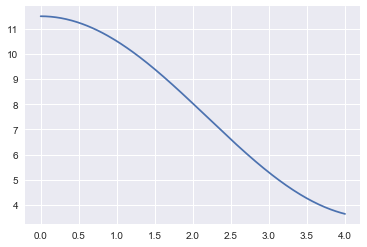

In [2]:
#Les dejo mientras tanto los datos para que los vean
datos = pd.read_csv('data.csv')
plt.plot(datos.Tiempo, datos.Posición)

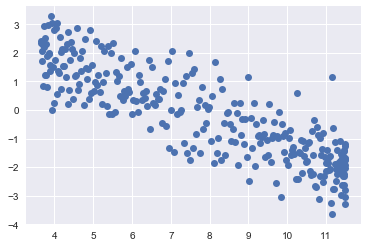

In [3]:
dt = datos.Tiempo[1]- datos.Tiempo[0]
p = pd.DataFrame({'p-': datos.Posición.shift(1), 'p0': datos.Posición.shift(0), 'p+': datos.Posición.shift(-1)})
dif = pd.DataFrame(
    {'y': p.apply(lambda row: (row['p-']-2*row['p0']+row['p+'])/dt**2, axis = 1), #Aceleración
     'x': datos.Posición.values} #Posición
)
dif = dif.dropna(axis=0)
plt.plot(dif.x, dif.y,'o')

Los valores encontrados son k = 6.212713020968865 y x0 =  7.503279634048742


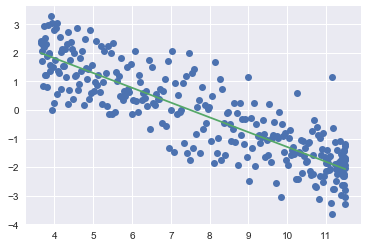

In [4]:
def cov(x,y):
    return np.mean(np.multiply(x,y)) - np.mean(x) * np.mean(y)

m = cov(dif.x,dif.y) / cov(dif.x,dif.x)
b = (np.mean(dif.x**2) * np.mean(dif.y) - np.mean(dif.x) * np.mean(np.multiply(dif.x,dif.y))) / cov(dif.x,dif.x)

f = np.vectorize(lambda s: m*s + b)

masa = 12
print("Los valores encontrados son k =", -m*masa, "y x0 = ", -b / m)

plt.plot(dif.x, dif.y, 'o')
plt.plot(dif.x, f(dif.x))

## Regresión multivariada

Ahora un poco más complicado pero no imposible. El archivo de datos 'casas.csv' contiene información sobre las características de 400 casas apócrifas, incluyendo el precio en el que han sido vendidas.

In [5]:
casas = pd.read_csv('casas.csv')
casas.head()

,Precio,Zona,No_Baños,No_Cuartos,Superficie
0,4628135.0,3.0,1.0,1.0,120.0
1,2057167.0,1.0,2.0,3.0,581.0
2,396796.0,0.0,1.0,1.0,99.0
3,2729222.0,2.0,1.0,4.0,232.0
4,868960.0,0.0,1.0,2.0,283.0


Los campos son los siguientes:
1. **Precio**: Precio en que la casa fue vendida. Algunas casas son _demasiado caras_ y pueden meter ruido a la predicción.
2. **Zona**: Categoría del vecindario en el que la casa se encuentra. Las categorías van del 0 (la zona más fea) al 4 (Al lado del parque _La Mexicana_) Se sabe que los números no representan linealmente el ascenso en precio de las casas.
3. **No_Baños**: Número de baños en la casa
4. **No_Cuartos**: Número de cuartos en la casa
5. **Superficie**: Superficie de la casa

Busque un modelo lineal que pueda predecir el costo de una casa en la zona 3, de 2 baños y 4 recámaras con $300m^2$ de superficie.

Además de eso, de una interpretación de cada entrada del vector de parámetros del modelo.

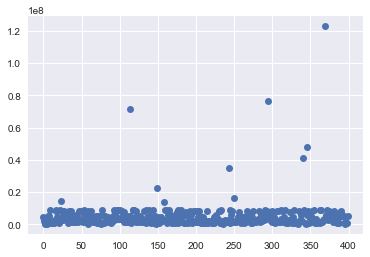

In [6]:
#Solución aquí (recuerden que con alt+enter generan más cuadritos para escribir y explicar)
plt.plot(range(casas.shape[0]),casas.Precio,'o')

In [7]:
filtCasas = casas[casas['Precio'] < 11000000]
print(filtCasas.shape)
deps = ['Zona', 'No_Baños', 'No_Cuartos', 'Superficie']
modifiedCasas = filtCasas[deps]
modifiedCasas.loc[:, 'Zona'] = modifiedCasas.Zona.apply(lambda j: j**2)
modifiedCasas.insert(0,'Compensate', 1)
A = np.matmul(modifiedCasas.T.values, modifiedCasas.values)
c = np.linalg.solve(A, np.matmul(modifiedCasas.T.values, filtCasas['Precio'].values))
print(c)

(390, 5)
[100480.43450283 466848.71176749  16606.70482822  50484.36491275
   2208.44688945]


Como parte final, para que comiencen a sentir el **poder**, aquí está una función que tomará el parámetro de su modelo, y lo evaluará en una partición de datos conocidos, a ver qué tan bien pueden predecir. La lambda que toma como segundo argumento es una función que se aplica a la columna "Zona". Relative es para dividir entre el precio medio aproximado de las casas (Sólo es para hacer el número un tanto más pequeño). Y así es como comienza la competencia.

In [8]:
QLFScore(c, zoneFunction = lambda j: j**2, relative = True)

El error cuadrático es: 50.13833699434988 (menor es mejor)


50.13833699434988

In [9]:
c

array([100480.43450283, 466848.71176749,  16606.70482822,  50484.36491275,
         2208.44688945])